# Классификация

## Загрузка данных, разведочный анализ и предобработка данных

In [1]:
!pip install numpy==1.21.5

In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("Employee.csv")

In [4]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [5]:
df.shape

(4653, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


In [7]:
print(df["Education"].value_counts())
print(end = "\n")
print(df["City"].value_counts())
print(end = "\n")
print(df["EverBenched"].value_counts())
print(end = "\n")
print(df["Gender"].value_counts())

Bachelors    3601
Masters       873
PHD           179
Name: Education, dtype: int64

Bangalore    2228
Pune         1268
New Delhi    1157
Name: City, dtype: int64

No     4175
Yes     478
Name: EverBenched, dtype: int64

Male      2778
Female    1875
Name: Gender, dtype: int64


In [8]:
display(df.describe(include=[np.number]).T)
display(df.describe(include=['object', 'category']).T)

,count,mean,std,min,25%,50%,75%,max
JoiningYear,4653.0,2015.062970,1.863377,2012.0,2013.0,2015.0,2017.0,2018.0
PaymentTier,4653.0,2.698259,0.561435,1.0,3.0,3.0,3.0,3.0
Age,4653.0,29.393295,4.826087,22.0,26.0,28.0,32.0,41.0
ExperienceInCurrentDomain,4653.0,2.905652,1.558240,0.0,2.0,3.0,4.0,7.0
LeaveOrNot,4653.0,0.343864,0.475047,0.0,0.0,0.0,1.0,1.0


,count,unique,top,freq
Education,4653,3,Bachelors,3601
City,4653,3,Bangalore,2228
Gender,4653,2,Male,2778
EverBenched,4653,2,No,4175


In [9]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Удалено дубликатов: {before - after} | Текущий размер: {df.shape}")

Удалено дубликатов: 1889 | Текущий размер: (2764, 9)


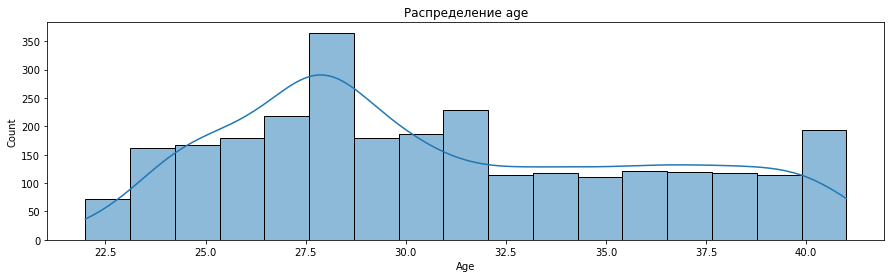

In [10]:
plt.figure(figsize = (15,4))
sns.histplot(df['Age'],kde = True)
plt.title("Распределение age")
# plt.tight_layout()
plt.show()

Пропусков в данных нет, закодируем категориалные признаки и проведем нормализацию.

In [11]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df["Gender"] = enc.fit_transform(df["Gender"])
df["EverBenched"] = enc.fit_transform(df["EverBenched"])

encoded_sub_type = pd.get_dummies(df["Education"],prefix = 'Education', drop_first=True).astype('int')
encoded_con_len = pd.get_dummies(df['City'],prefix = 'City', drop_first=True).astype('int')

df = pd.concat([df, encoded_sub_type, encoded_con_len], axis=1)

df.drop(columns=['Education', 'City'], inplace=True)

In [12]:
df.head()

,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Education_Masters,Education_PHD,City_New Delhi,City_Pune
0,2017,3,34,1,0,0,0,0,0,0,0
1,2013,1,28,0,0,3,1,0,0,0,1
2,2014,3,38,0,0,2,0,0,0,1,0
3,2016,3,27,1,0,5,1,1,0,0,0
4,2017,3,24,1,1,2,1,1,0,0,1


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    df.drop("LeaveOrNot", axis=1),
    df["LeaveOrNot"],
    test_size=0.33,
    random_state=42
)

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)
X_train.shape, X_test.shape, X_train_scaled.shape, X_test_scaled.shape, Y_train.shape, Y_test.shape

((1851, 10), (913, 10), (1851, 10), (913, 10), (1851,), (913,))

## Подбор модели

### Подготовка необходимых функций

In [15]:
from sklearn.metrics import (
    accuracy_score, # доля правильных ответов
    precision_score, # точность
    recall_score, # полнота
    confusion_matrix,
    f1_score, # F1-мера
)

In [16]:
def plot_confusion(model,Y_test,X_test):
    confusion = confusion_matrix(Y_test, model.predict(X_test))
    df_cm = pd.DataFrame(confusion * 100 / np.sum(confusion), index=[i for i in ['Остался', 'Ушел']],
                         columns=[i for i in ['Остался', 'Ушел']])
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True)

def make_model(model, X_train, y_train, X_test, y_test, bar_plot=False):
    model.fit(X_train, y_train)

    print(f'Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}')
    print(f'Accuracy train: {accuracy_score(y_train, model.predict(X_train)):.4f}')
    print(f'Precision_micro: {precision_score(y_test, model.predict(X_test), average="micro"):.4f}')
    print(f'Precision_macro: {precision_score(y_test, model.predict(X_test), average="macro"):.4f}')
    print(f'Recall_micro: {recall_score(y_test, model.predict(X_test), average="micro"):.4f}')
    print(f'Recall_macro: {recall_score(y_test, model.predict(X_test), average="macro"):.4f}')
    print('F score:', f1_score(y_test, model.predict(X_test), average='weighted'))
    print('Confusion matrix:\n', confusion_matrix(y_test, model.predict(X_test)))
    plot_confusion(model,y_test,X_test)
    if bar_plot:
        features = X_train.columns
        importances = model.feature_importances_
        indices = np.argsort(importances)

        plt.figure(2)
        plt.title('Feature importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), features[indices])
        plt.xlabel('Relative Importance')
        plt.show()

### Метод ближайшего соседа

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scores = []

for k in range(1, 30):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_scaled, Y_train)
    y_pred = model.predict(X_test_scaled)
    scores.append(accuracy_score(Y_test, y_pred))

best_k = scores.index(max(scores)) + 1

print(f"Лучший k: {best_k}")


Лучший k: 7


Accuracy: 0.7448
Accuracy train: 0.7996
Precision_micro: 0.7448
Precision_macro: 0.7475
Recall_micro: 0.7448
Recall_macro: 0.7177
F score: 0.7367163019614512
Confusion matrix:
 [[468  69]
 [164 212]]


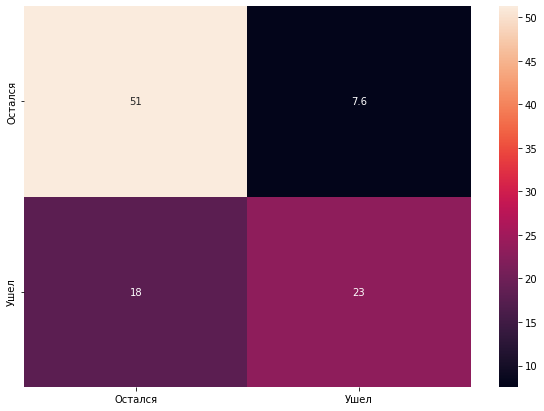

In [18]:
neigh = KNeighborsClassifier(n_neighbors=best_k)
make_model(neigh,X_train_scaled, Y_train, X_test_scaled, Y_test)

### Деревья решений

In [19]:
def get_train_and_test_accuracy(param_name, grid):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название варьируемого параметра,
    2) grid - сетка значений параметра
    '''
        
    train_acc, test_acc = [], []
    
    for param_value in grid:
        estimator = DecisionTreeClassifier(**{param_name: param_value})
        estimator.fit(X_train_scaled, Y_train)
        train_acc.append(accuracy_score(Y_train, estimator.predict(X_train_scaled)))
        test_acc.append(accuracy_score(Y_test, estimator.predict(X_test_scaled)))
    return train_acc, test_acc

In [20]:
def plot_dependence(param_name, grid=range(2, 20), title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) title - заголовок графика
    '''
    
    plt.figure(figsize=(12, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(param_name, grid)
        
    plt.plot(grid, train_acc, label='train', lw=3)
    plt.plot(grid, test_acc, label='test', lw=3)
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Точность классификации')
    plt.title(title, fontsize=20)
    plt.show()

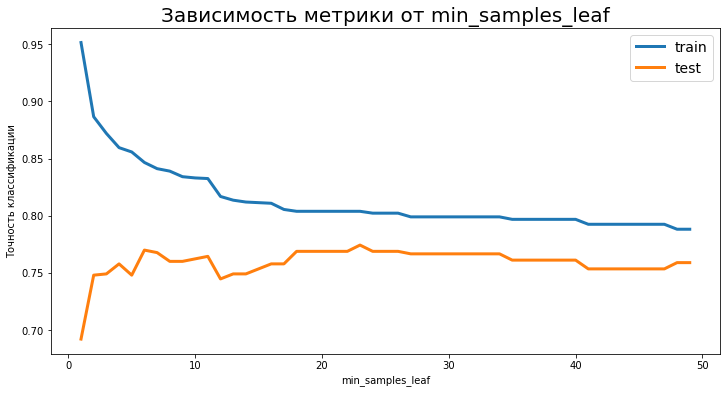

In [21]:
from sklearn.tree import DecisionTreeClassifier

plot_dependence(
    'min_samples_leaf', range(1, 50), 
    title='Зависимость метрики от min_samples_leaf'
)

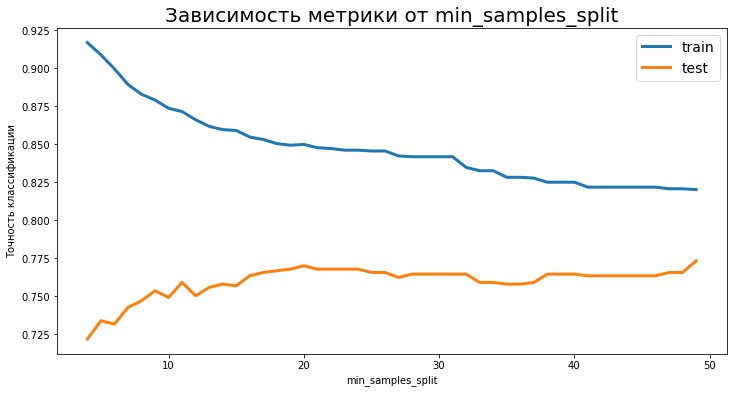

In [22]:
plot_dependence(
    'min_samples_split', range(4, 50), 
    title='Зависимость метрики от min_samples_split'
)

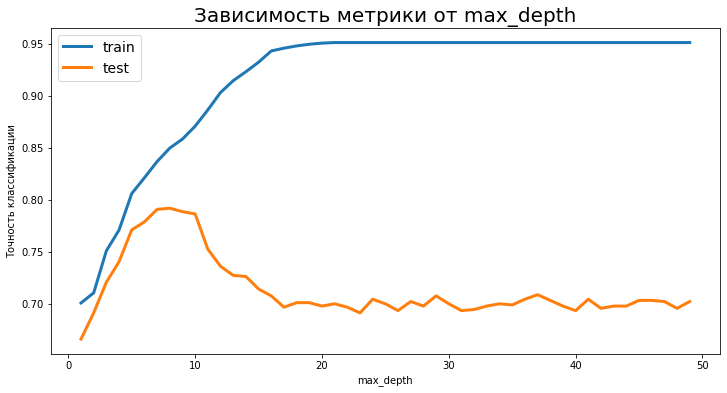

In [23]:
plot_dependence(
    'max_depth', range(1, 50), 
    title='Зависимость метрики от max_depth'
)

Accuracy: 0.7689
Accuracy train: 0.8023
Precision_micro: 0.7689
Precision_macro: 0.7847
Recall_micro: 0.7689
Recall_macro: 0.7378
F score: 0.7586967545561351
Confusion matrix:
 [[491  46]
 [165 211]]


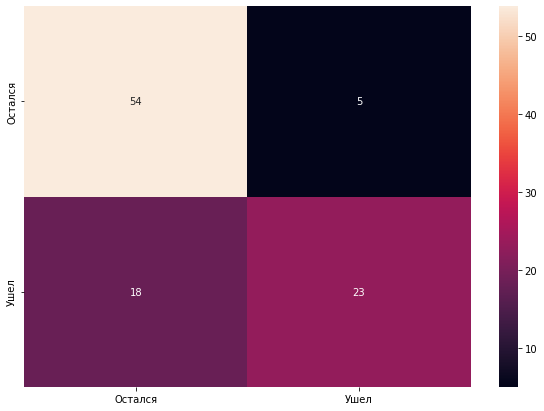

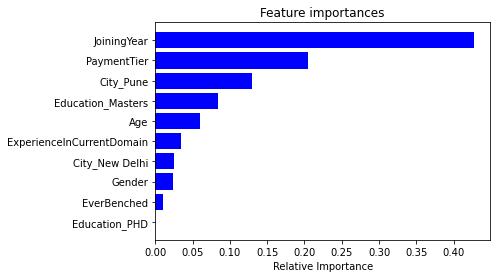

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(
    max_depth = 8,
    min_samples_split = 20,
    min_samples_leaf = 25,
    random_state=2025)
make_model(dtc,X_train_scaled, Y_train, X_test_scaled, Y_test, bar_plot=True)

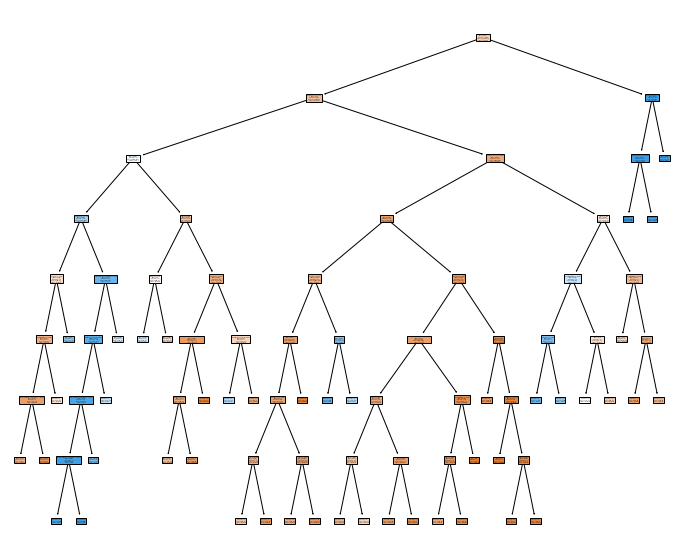

In [25]:
# Посмотрим на получившееся дерево классификации
from sklearn import tree
plt.figure(figsize=(12, 10))
tree.plot_tree(dtc,feature_names=list(X_train_scaled), class_names=['Остался', 'Ушел'], filled=True,);

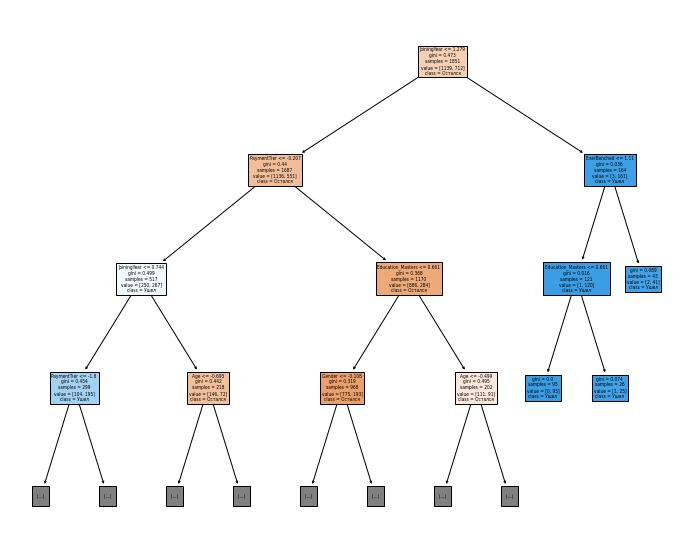

In [26]:
# Обрезанное дерево на глубину 2
plt.figure(figsize=(12, 10))
tree.plot_tree(dtc,
               feature_names=list(X_train_scaled),
               class_names=['Остался', 'Ушел'],
               filled=True,
              max_depth=3);

### Случайный лес

Accuracy: 0.7251
Accuracy train: 0.9514
Precision_micro: 0.7251
Precision_macro: 0.7190
Recall_micro: 0.7251
Recall_macro: 0.7037
F score: 0.7201297911251779
Confusion matrix:
 [[443  94]
 [157 219]]


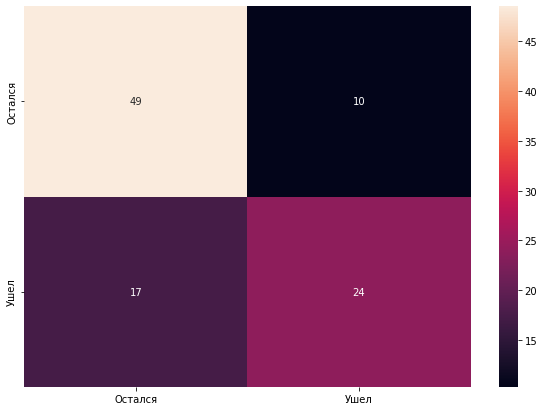

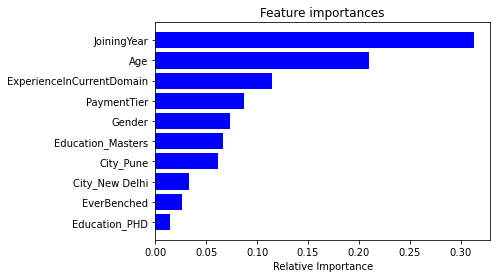

In [27]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)
make_model(rfc, X_train_scaled, Y_train, X_test_scaled, Y_test,bar_plot=True)

In [28]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': [3, 5, 10],
    'min_samples_leaf': [1, 5, 7],
    'max_depth': [None, 15, 30, 40],
    'criterion': ['gini', 'entropy']
}

rf_param = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_param, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train)

print('Best parameters:', grid_search.best_params_)
print(f'Наилучшая точность: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 7, 'n_estimators': 50}
Наилучшая точность: 0.8163


Accuracy: 0.7886
Accuracy train: 0.8379
Precision_micro: 0.7886
Precision_macro: 0.8081
Recall_micro: 0.7886
Recall_macro: 0.7585
F score: 0.7795175617807982
Confusion matrix:
 [[499  38]
 [155 221]]


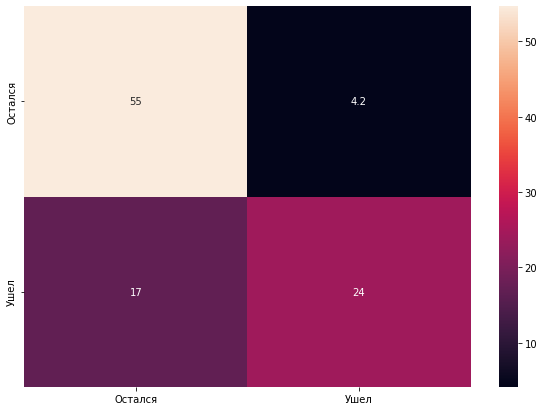

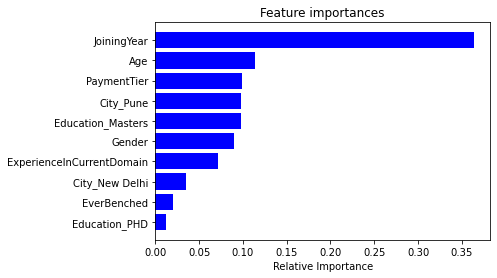

In [31]:
rf_best = RandomForestClassifier(n_estimators=50,
                            max_features=5,
                            min_samples_leaf=7,
                            # max_depth=None,
                            criterion='entropy')
rf_best.fit(X_train_scaled, Y_train)

y_pred = rf_best.predict(X_test_scaled)

rfc = RandomForestClassifier(max_depth=30)
make_model(rf_best, X_train_scaled, Y_train, X_test_scaled, Y_test,bar_plot=True)

### Lightgbm


In [32]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [33]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [34]:
num_leaves = 10 
min_data_in_leaf = 5
max_depth = 4

lgbm = LGBMClassifier(num_leaves=num_leaves,
                      min_data_in_leaf=min_data_in_leaf,
                      max_depth=max_depth)

cv = RepeatedStratifiedKFold(n_splits=10,
                             n_repeats=3,
                             random_state=42)
n_scores = cross_val_score(lgbm, X_train_scaled, Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Точность: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Точность: 0.811 (0.026)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Number of positive: 712, number of negative: 1139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 1851, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384657 -> initscore=-0.469828
[LightGBM] [Info] Start training from score -0.469828
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Accuracy

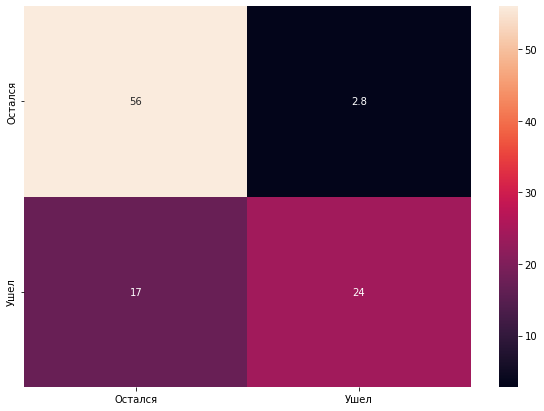

In [35]:
# lgbm = LGBMClassifier()
make_model(lgbm, X_train_scaled, Y_train, X_test_scaled, Y_test)

In [36]:
param_grid = {
    'num_leaves': [5, 10, 15, 31],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [-1, 5, 10]
}
lgbm_1 = LGBMClassifier(boosting_type='gbdt')

grid = GridSearchCV(
    estimator=lgbm_1,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, Y_train)

print("Лучшие параметры:", grid.best_params_)
print(f"Лучшая точность: {grid.best_score_:.4f}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 712, number of negative: 1139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 1851, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384657 -> initscore=-0.469828
[LightGBM] [Info] Start training from score -0.469828
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 50, 'num_leaves': 10}
Лучшая точность: 0.8185


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 712, number of negative: 1139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 1851, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384657 -> initscore=-0.469828
[LightGBM] [Info] Start training from score -0.469828
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 712, number of negative: 1139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

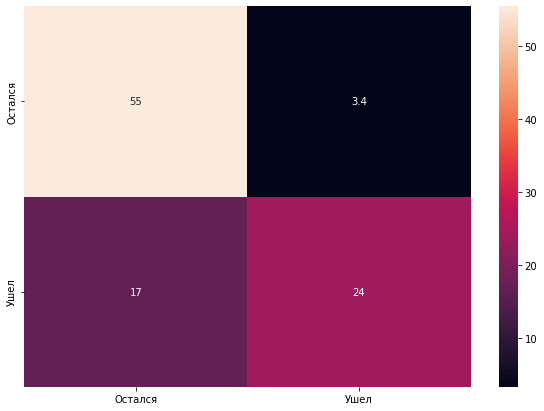

In [37]:
best_lgbm = grid.best_estimator_

best_lgbm.fit(X_train_scaled, Y_train)
y_pred = best_lgbm.predict(X_test_scaled)
make_model(best_lgbm, X_train_scaled, Y_train, X_test_scaled, Y_test)

### shap

ERROR: Ignored the following versions that require a different python version: 1.25.0 Requires-Python >=3.9; 1.25.1 Requires-Python >=3.9; 1.25.2 Requires-Python >=3.9; 1.26.0 Requires-Python <3.13,>=3.9; 1.26.1 Requires-Python <3.13,>=3.9; 1.26.2 Requires-Python >=3.9; 1.26.3 Requires-Python >=3.9; 1.26.4 Requires-Python >=3.9; 2.0.0 Requires-Python >=3.9; 2.0.1 Requires-Python >=3.9; 2.0.2 Requires-Python >=3.9; 2.1.0 Requires-Python >=3.10; 2.1.1 Requires-Python >=3.10; 2.1.2 Requires-Python >=3.10; 2.1.3 Requires-Python >=3.10; 2.2.0 Requires-Python >=3.10; 2.2.1 Requires-Python >=3.10; 2.2.2 Requires-Python >=3.10; 2.2.3 Requires-Python >=3.10; 2.2.4 Requires-Python >=3.10; 2.2.5 Requires-Python >=3.10; 2.2.6 Requires-Python >=3.10; 2.3.0 Requires-Python >=3.11; 2.3.1 Requires-Python >=3.11; 2.3.2 Requires-Python >=3.11; 2.3.3 Requires-Python >=3.11; 2.3.4 Requires-Python >=3.11; 2.3.5 Requires-Python >=3.11; 2.4.0rc1 Requires-Python >=3.11
ERROR: Could not find a version that sat

In [39]:
!pip install shap

In [40]:
import shap

In [41]:
#shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)

explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test_scaled)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Важность переменных

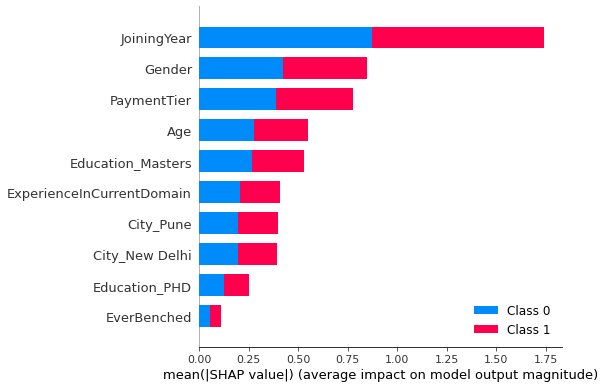

In [42]:
# Построение графиков влияния признаков на предсказания
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")

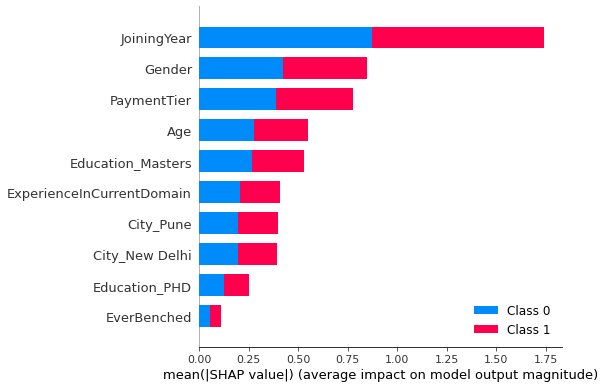

In [43]:
shap.summary_plot(shap_values, X_test_scaled, show=False)

In [48]:
shap_values

[array([[-4.60248166,  0.07954908,  0.16928962, ..., -0.02667771,
         -0.08479158, -0.01166961],
        [ 0.33122949, -0.95517075, -0.03394182, ...,  2.09115357,
         -0.08542085, -0.72962683],
        [ 0.39396653,  0.31291037,  0.20757301, ..., -0.06902888,
         -0.18463259, -0.06399209],
        ...,
        [ 0.62363294,  0.24568738,  0.29348309, ..., -0.0386102 ,
          0.54672323, -0.04822546],
        [-0.00625151,  0.37827066, -0.36447044, ..., -0.09073383,
         -0.13697219, -0.59680442],
        [ 0.15081268, -1.2479332 ,  0.06277741, ..., -0.10630508,
         -0.06952046, -0.71837104]]),
 array([[ 4.60248166, -0.07954908, -0.16928962, ...,  0.02667771,
          0.08479158,  0.01166961],
        [-0.33122949,  0.95517075,  0.03394182, ..., -2.09115357,
          0.08542085,  0.72962683],
        [-0.39396653, -0.31291037, -0.20757301, ...,  0.06902888,
          0.18463259,  0.06399209],
        ...,
        [-0.62363294, -0.24568738, -0.29348309, ...,  

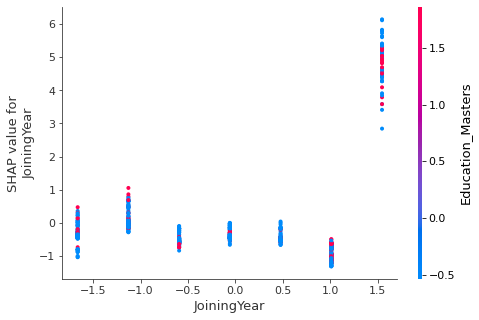

In [50]:
shap.dependence_plot("JoiningYear", shap_values[1], X_test_scaled, interaction_index="Education_Masters")

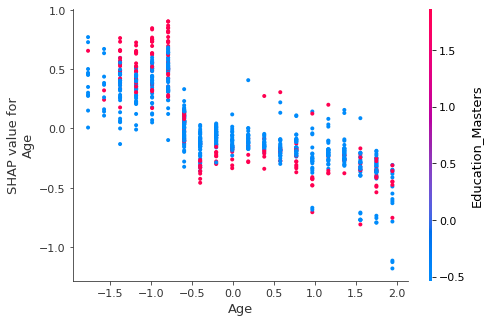

In [52]:
shap.dependence_plot("Age", shap_values[1], X_test_scaled, interaction_index="Education_Masters")

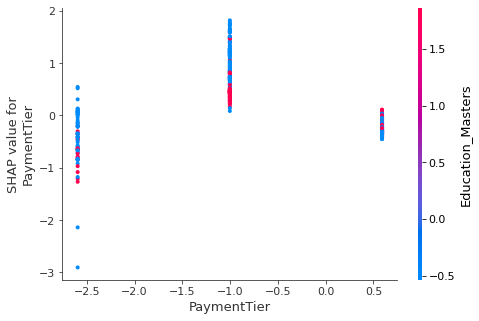

In [54]:
shap.dependence_plot("PaymentTier", shap_values[1], X_test_scaled, interaction_index="Education_Masters")

#### Графики силы влияния

In [61]:
explainer1 = shap.Explainer(lgbm, X_train_scaled)
shap_values1 = explainer1(X_test_scaled)

In [62]:
X_test_scaled.head()

,JoiningYear,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Education_Masters,Education_PHD,City_New Delhi,City_Pune
0,1.546255,0.589487,1.360644,0.897694,2.603327,0.219436,-0.537585,-0.257380,-0.625047,-0.647672
1,-0.058371,-1.003419,-0.205498,-1.113966,-0.384124,0.846252,-0.537585,3.885312,-0.625047,1.543992
2,-1.662997,0.589487,-0.401266,0.897694,-0.384124,0.846252,-0.537585,-0.257380,-0.625047,-0.647672
3,-0.058371,0.589487,-1.771640,0.897694,2.603327,-1.661011,-0.537585,-0.257380,-0.625047,-0.647672
4,1.011380,-2.596324,-0.205498,0.897694,-0.384124,-1.034195,-0.537585,-0.257380,-0.625047,-0.647672


In [63]:
Y_test.head()

3571    1
2519    0
2853    0
4325    0
2755    0
Name: LeaveOrNot, dtype: int64

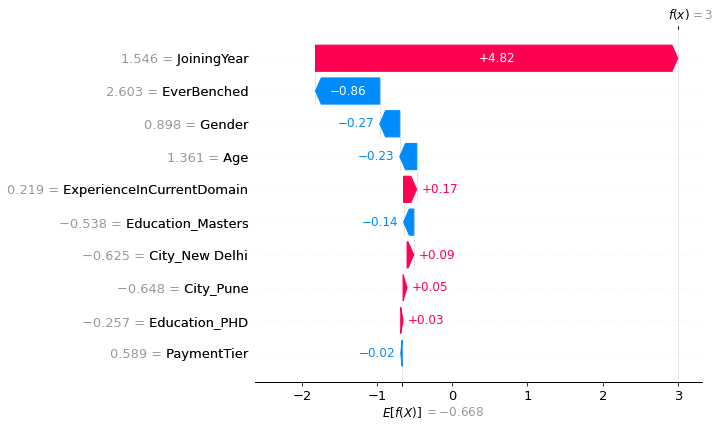

In [64]:
shap.plots.waterfall(shap_values1[0])

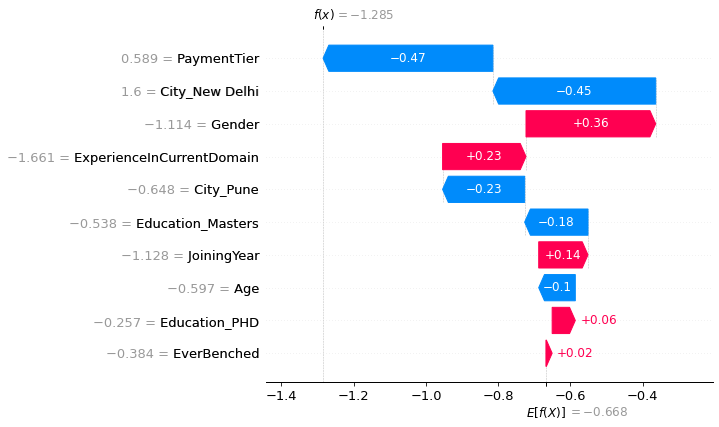

In [65]:
shap.plots.waterfall(shap_values1[30])

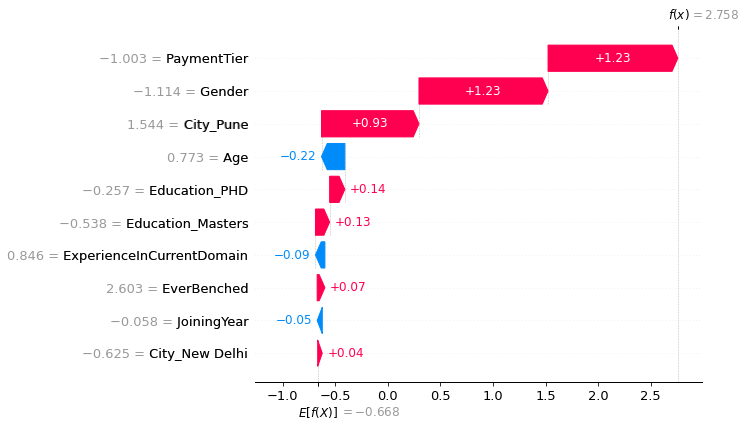

In [67]:
shap.plots.waterfall(shap_values1[11])